In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [2]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

from scipy.optimize import lsq_linear
def unmixing(features, cell, n_feature):
    b = features['ave_intensity'].loc[cell][: n_feature] 
    wls = features['wavelengths'].loc[cell][: n_feature]

    A = np.empty((len(b), len(mols)))
    for wl in wls:
        for i, mol in enumerate(mols):
            j = [j for j, col in enumerate(dfs[mol].columns[:-1]) 
                 if (dfs[mol].columns[j] <= wl[0] < dfs[mol].columns[j+1])][0]
            if wl[0] - dfs[mol].columns[j] > dfs[mol].columns[j + 1]- wl[0]:
                j += 1
            ex = dfs[mol].columns[j]

            k = [k for k, idx in enumerate(dfs[mol].index[:-1]) 
                 if (dfs[mol].index[k] > wl[1] >= dfs[mol].index[k+1])][0]
            if dfs[mol].index[k] - wl[1] < wl[1] - dfs[mol].index[k + 1]:
                k += 1
            em = dfs[mol].index[k]

            A[wls.index(wl), i] = dfs[mol].at[em, ex]
    res = lsq_linear(A, b, bounds=(0, np.inf), method='trf')

    return res

In [3]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/unmixing_gene/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.var` of view, copying.


filter genes
Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


## unmixing

In [10]:
mols = ['Free NAD(P)H', 'Protein bound NAD(P)H']

fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/matrix_data_range/'
dfs = {name: pd.read_csv(fdn + name.replace(' ', '_') + '.tsv', sep='\t', index_col=0) for name in mols}

for mol in mols:
    dfs[mol].index = dfs[mol].index.astype('float')
    dfs[mol].columns = dfs[mol].columns.astype('float')

In [11]:
n_feature = 7
abundance = pd.DataFrame([], columns=mols)
features = adata.obs.copy()
for cell in features.index:
    abundance.loc[cell] = unmixing(features, cell, n_feature)['x']
abundance.to_csv(save_figures + 'NADH_abundance.tsv', sep='\t')

## correlations

In [23]:
def get_correlation(adata, feas):
    
    exp = adata.X.T
    phe = adata.obs[feas].fillna(0)

    x = exp
    y = phe.values.T

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata, fea, xlabel, path, filetype=False):
    
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata.obs[fea]
            y = adata[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = int(exp.shape[0] / bin_n)
        idx = np.arange(n) + n * i
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median()
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/max(med) for i in med]
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

In [5]:
abundance = pd.read_csv(save_figures + 'NADH_abundance.tsv', sep='\t', index_col=0)
# compute the correlations between PC1, PC2 and gene expression
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']
for fea in feas:
    adata.obs[fea] = abundance.loc[adata.obs_names][fea]
    
# corr = get_correlation(adata, feas)
# corr.to_csv(save_figures + 'correlation_abundance.tsv', sep='\t')

corr = pd.read_csv(save_figures + 'correlation_abundance.tsv', sep='\t', index_col=0)

In [6]:
# percentage of cells expressing this gene
pct = 0.8
gene_pct = pd.Series((adata.X > 0).sum(axis=0) / adata.obs.shape[0], index=adata.var_names)
high_pct = gene_pct[gene_pct >= pct].index

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


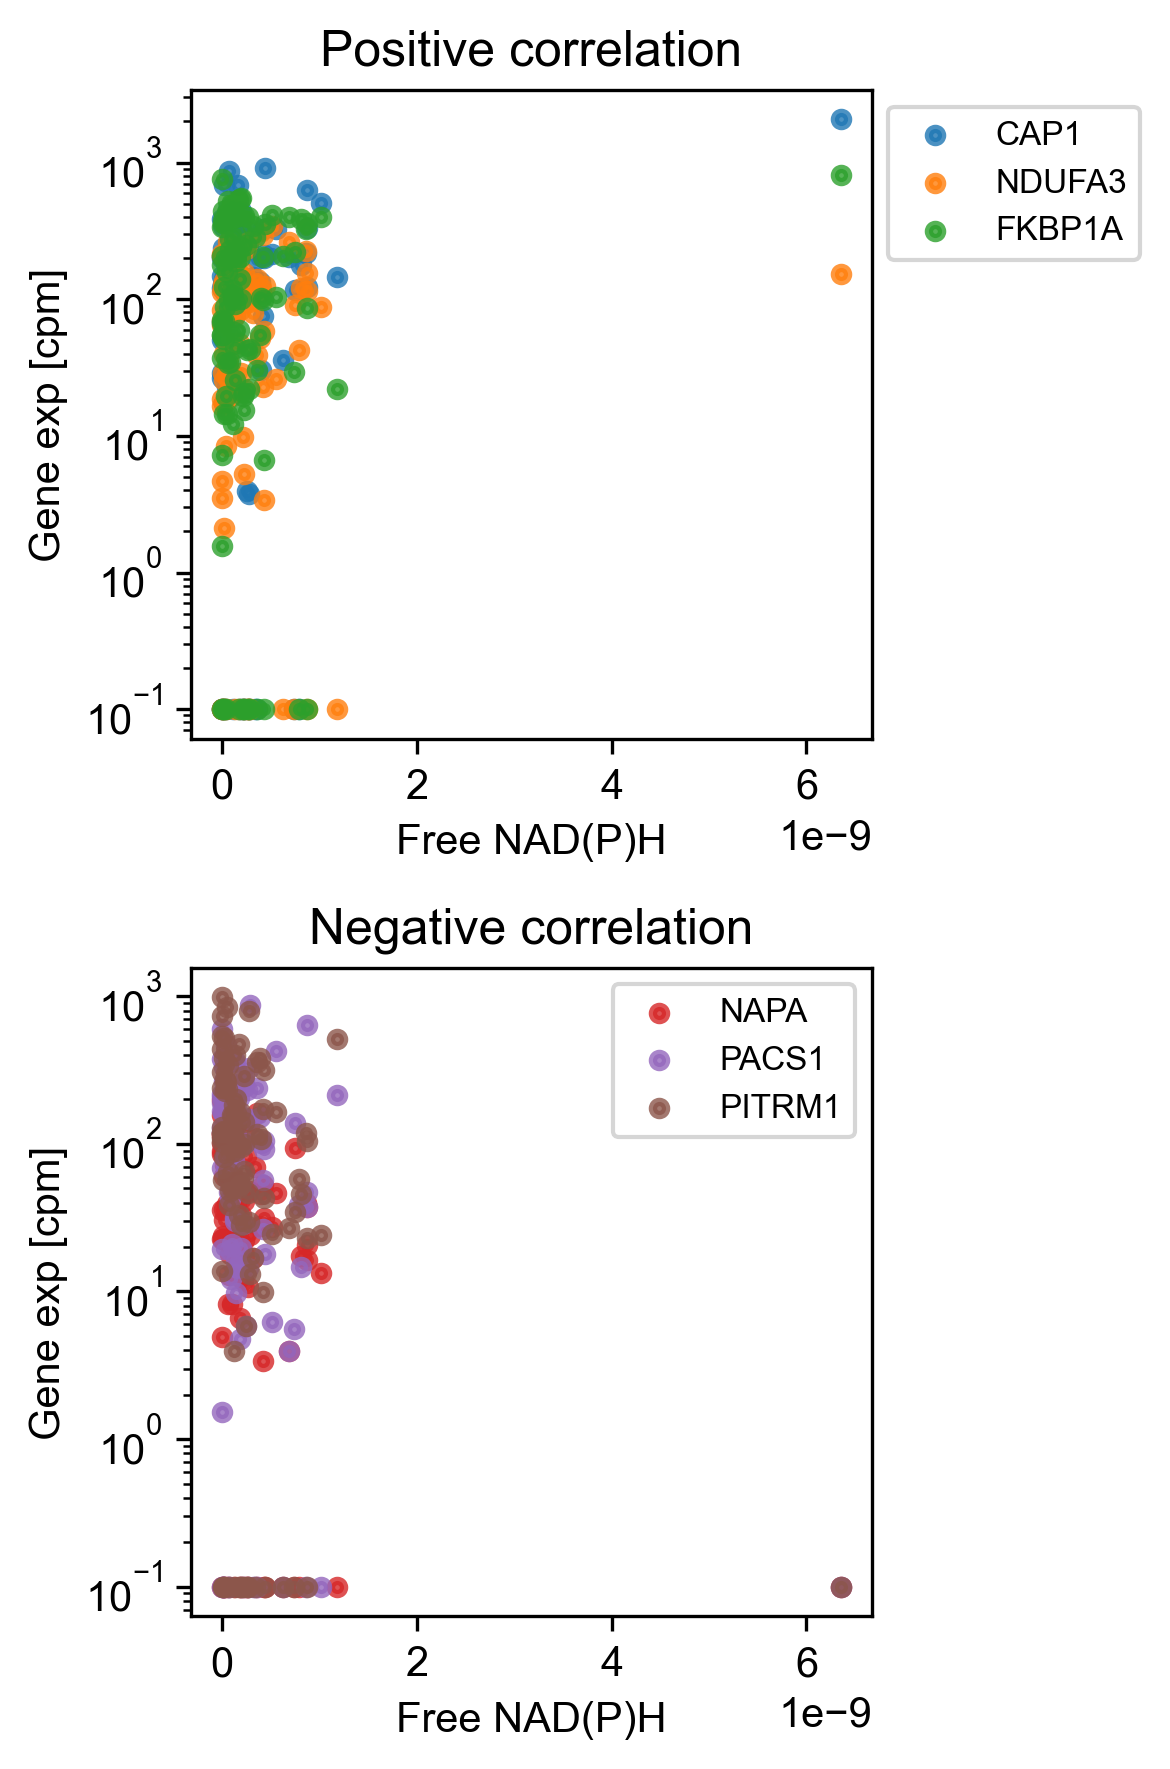

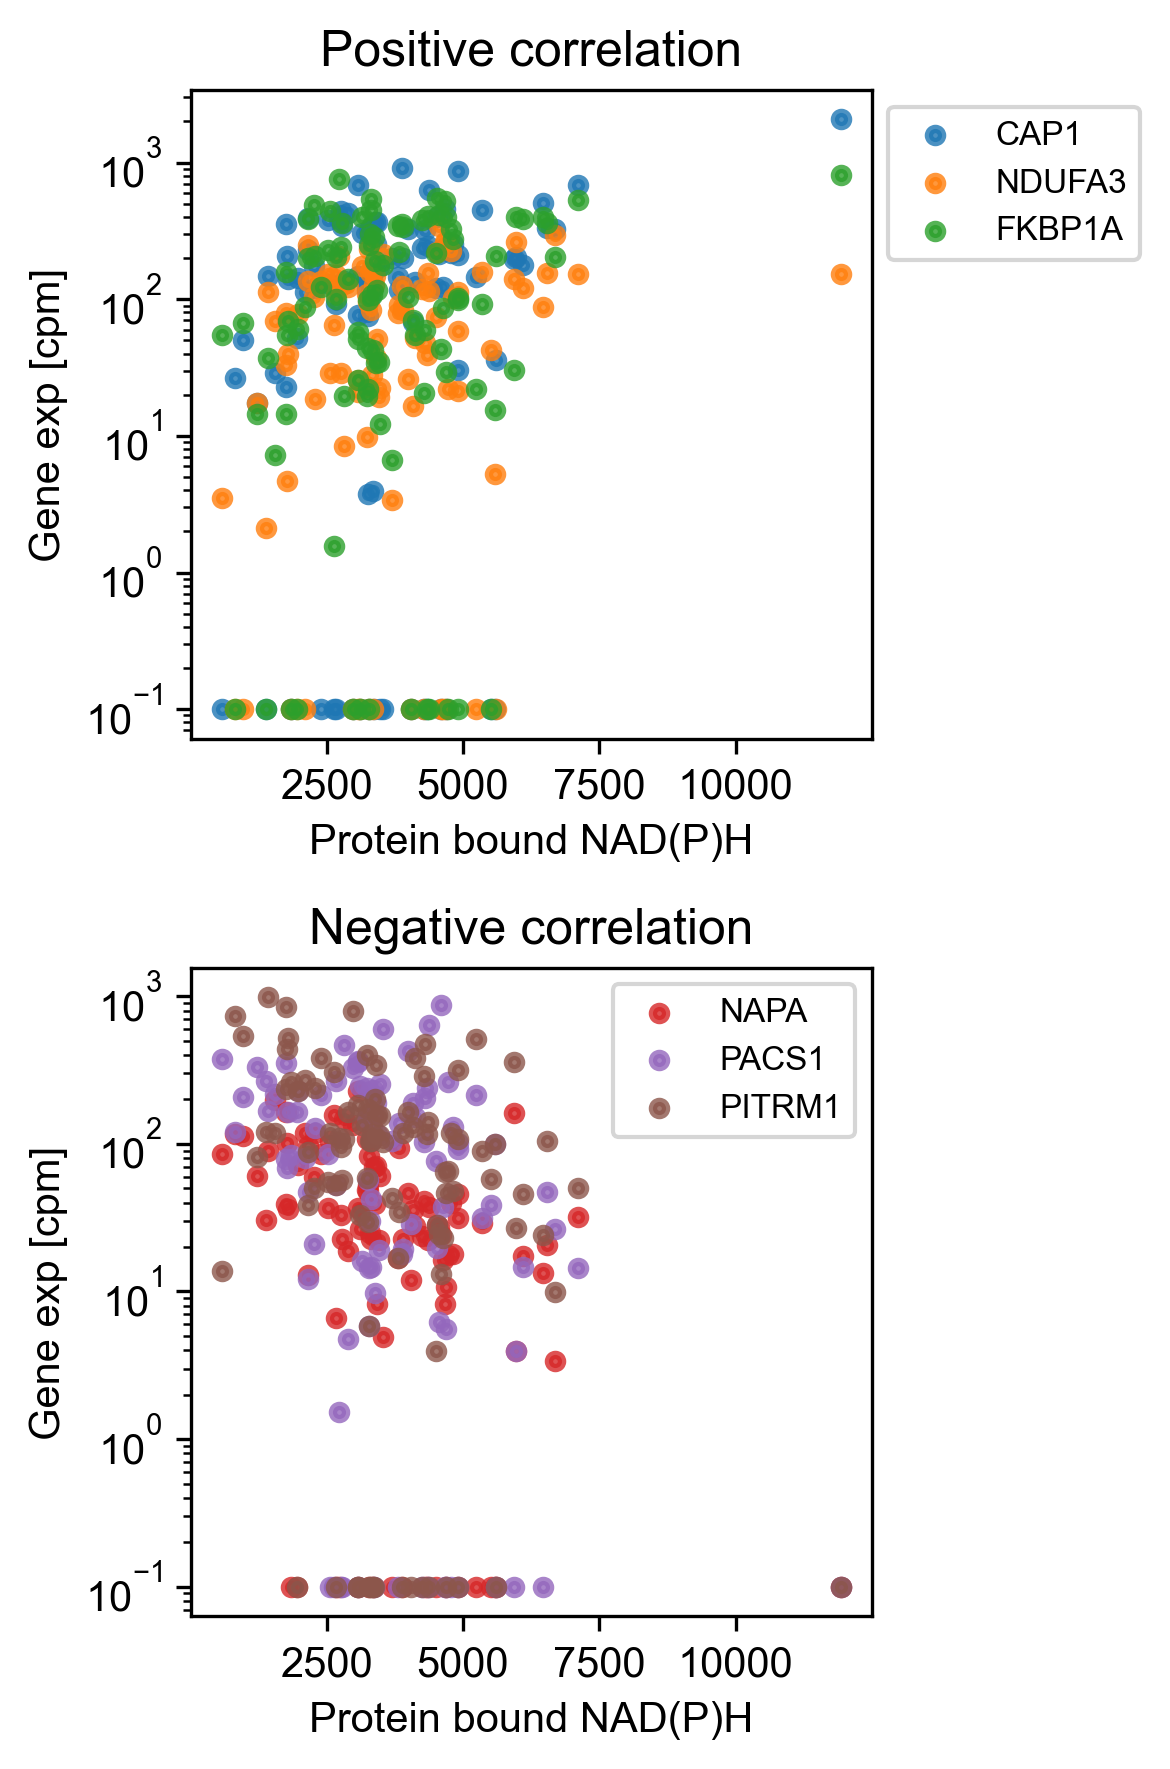

In [38]:
# plot the 3 genes with highest positive or negative correlations
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']
xlabels = ['Free NAD(P)H', 'Protein bound NAD(P)H']

for fea, xlabel in zip(feas, xlabels):
    pos_genes = ['CAP1', 'NDUFA3', 'FKBP1A']
#     neg_genes = corr.loc[high_pct].nsmallest(3, fea).index
    neg_genes = ['NAPA', 'PACS1', 'PITRM1']

    path = save_figures
    filetype = '.png' 
    genes = {
        'positive': pos_genes,
        'negative': neg_genes,
    }
    plot_correlation(genes, adata, fea, xlabel, path, filetype='1.pdf')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

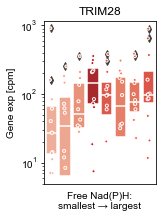

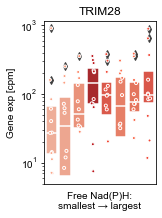

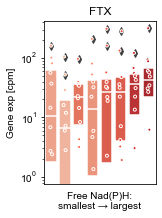

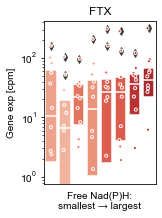

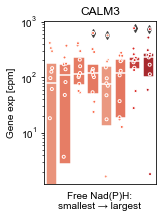

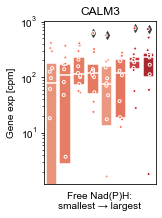

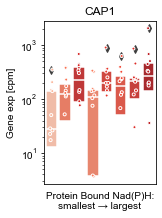

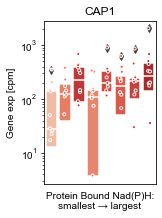

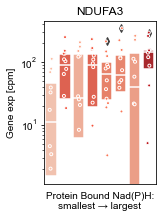

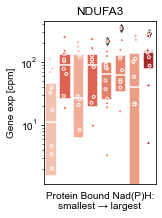

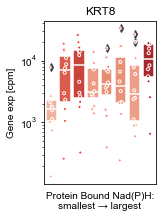

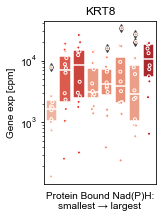

In [33]:
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']

for fea in feas:
    pos = corr.loc[high_pct].nlargest(3, fea).index

    for gene in pos:
        cmap = 'Reds'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

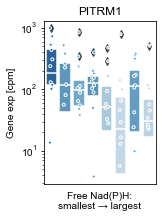

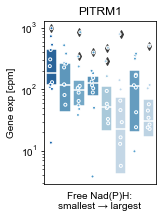

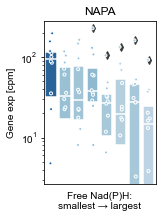

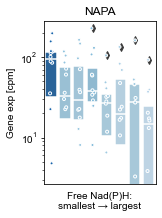

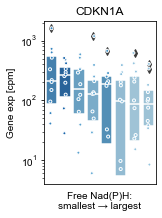

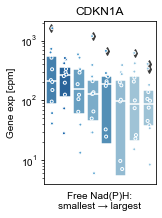

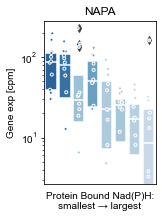

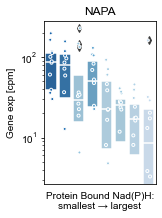

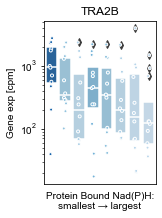

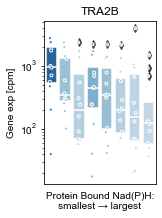

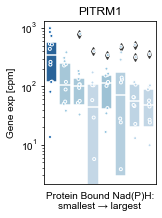

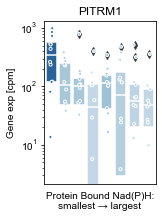

In [34]:
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']

for fea in feas:
    negs = corr.loc[high_pct].nsmallest(3, fea).index

    for gene in negs:
        cmap = 'Blues'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)

In [41]:
corr['Protein bound NAD(P)H'].sort_values()[:15]

gene_name
NAPA     -0.473579
CRTC1    -0.356329
PPM1H    -0.356298
CLDND1   -0.353059
RBM14    -0.349510
SMAD5    -0.341956
RP9      -0.341893
TRA2B    -0.341757
NR1H3    -0.341232
PITRM1   -0.327955
PACS1    -0.321074
BRAT1    -0.316145
ELL2     -0.315372
BAZ2A    -0.314362
RPS26    -0.311925
Name: Protein bound NAD(P)H, dtype: float64

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


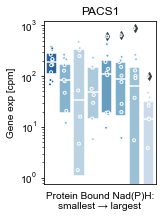

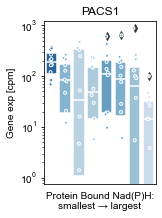

In [37]:
feas = ['Protein bound NAD(P)H']

for fea in feas:
    negs = ['PACS1']

    for gene in negs:
        cmap = 'Blues'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)